### Pipeline for a single openephys session
- Load an exctractor for visualization of the data
- Sort it using kilosort

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
from ceciestunepipe.file import bcistructure as et

In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-06-21 18:05:47,684 root         INFO     all modules loaded


In [5]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxoneextractors.maxoneextractors.MaxOneRecordingExtractor,
 spikeextractors.extractors.mea1kextractors.mea1kextractors.Mea1kRecordingExtractor,
 spikeextractors.extractors.mcsh5recordingextractor.mcsh5rec

In [6]:
si

<module 'spikeinterface' from '/mnt/cube/earneodo/repos/spikeinterface/spikeinterface/__init__.py'>

### Session parameters and raw files

In [7]:
reload(et)


bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)
all_bird_sess

['2021-05-29',
 '2021-06-05',
 '2021-05-23',
 '2021-06-16',
 '2021-05-30',
 '2021-06-11',
 '2021-06-08',
 '2021-06-02',
 '2021-05-24',
 '2021-05-12',
 '2021-05-20',
 '2021-06-06',
 '2021-06-15',
 '2021-06-18',
 '2021-06-12',
 '2021-06-20',
 '2021-05-27',
 '2021-06-01',
 '2021-06-03',
 '2021-05-25',
 '2021-06-09',
 '2021-06-10',
 '2021-06-17',
 '2021-05-31',
 '2021-06-04',
 '2021-05-22',
 '2021-05-28',
 '2021-05-26',
 '2021-06-13',
 '2021-06-19',
 '2021-06-21',
 '2021-06-14',
 '2021-05-21',
 '2021-06-07']

In [7]:
reload(et)

<module 'ceciestunepipe.file.bcistructure' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/file/bcistructure.py'>

In [8]:
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-21',
           'probe': 'probe_0', 
            'ephys_software': 'openephys', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['ephys_software'], sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['openephys']

In [9]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-21/openephys'

In [10]:
!ls /mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-12/sglx

1132_g0  1631.errors.txt  1631_g0  714_g0  rig.json


In [10]:
sess_epochs = et.list_ephys_epochs(sess_par)
sess_epochs

2021-06-21 18:07:52,175 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-21', 'openephys': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-21/openephys', 'kwik': '/scratch/earneodo/s_b1253_21/openephys/kwik/2021-06-21', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-21/openephys', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-21/openephys', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1253_21/openephys/msort/2021-06-21', 'ksort': '/scratch/earneodo/s_b1253_21/openephys/ksort/2021-06-21'}, 'files': {'par': '/scratch/earneodo/s_b1253_21/openephys/ksort/2021-06-21/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-21/openephys/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-21/openephys/rig.json', 'kwd': '/scratch/earneodo/s_b1253_21/openephys/kwik/2021-06-21

['rhythm_2021-06-21_17-29-33']

In [11]:
### pick a session
reload(et)
epoch = sess_epochs[0] # g2 is the shortest

#exp_struct = et.sgl_struct(sess_par, epoch)
#sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

#### use the https://github.com/open-ephys/open-ephys-python-tools package to navigate the openephys-recorded data

In [12]:
sess_epochs

['rhythm_2021-06-21_17-29-33']

In [13]:
from open_ephys import analysis as oea

In [14]:
epoch

'rhythm_2021-06-21_17-29-33'

In [134]:
epoch_path = os.path.join(exp_struct['folders']['openephys'], epoch)
oe_epoch = oea.Session(epoch_path)

In [135]:
print(oe_epoch)


Open Ephys Recording Session Object
Directory: /mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-21/openephys/rhythm_2021-06-21_17-29-33

<object>.recordnodes:
  Index 0: Record Node 105 (binary format)



In [136]:
cont_0 = oe_epoch.recordnodes[0].recordings[0].continuous[0]
cont_0

In [137]:
cont_0.samples.shape

(35209716, 384)

In [138]:
oe_epoch.recordnodes

In [139]:
oe_epoch.recordnodes[0].recordings[0]

In [140]:
rec0 = oe_epoch.recordnodes[0].recordings[0]

In [141]:
rec0.add_sync_channel(1, 103, 0, main=True)
rec0.add_sync_channel(1, 103, 1, main=False)
rec0.add_sync_channel(1, 100, 0, main=False)

In [142]:
rec0.compute_global_timestamps()

In [143]:
rec_ev = rec0.events
rec_ev

,channel,timestamp,processor_id,subprocessor_id,state,global_timestamp
0,1,3113084,103,1,0,1245.233433
1,1,3114334,103,1,1,1245.733433
2,1,3115584,103,1,0,1246.233433
3,1,3116834,103,1,1,1246.733433
4,1,3118084,103,1,0,1247.233433
...,...,...,...,...,...,...
7036,1,72528141,100,0,0,2417.236730
7037,1,72532102,103,0,1,2417.736733
7038,1,72543141,100,0,1,2417.736733
7039,1,72547103,103,0,0,2418.236767


### try a global timestamp plot of the square signals

In [144]:
rec_ev['sig'] = rec_ev['subprocessor_id'] + rec_ev['processor_id']
rec_ev['is_edge'] = 1

In [145]:
rec_ev

,channel,timestamp,processor_id,subprocessor_id,state,global_timestamp,sig,is_edge
0,1,3113084,103,1,0,1245.233433,104,1
1,1,3114334,103,1,1,1245.733433,104,1
2,1,3115584,103,1,0,1246.233433,104,1
3,1,3116834,103,1,1,1246.733433,104,1
4,1,3118084,103,1,0,1247.233433,104,1
...,...,...,...,...,...,...,...,...
7036,1,72528141,100,0,0,2417.236730,100,1
7037,1,72532102,103,0,1,2417.736733,103,1
7038,1,72543141,100,0,1,2417.736733,100,1
7039,1,72547103,103,0,0,2418.236767,103,1


In [155]:
first_20 = rec_ev[['sig', 'global_timestamp', 'state']]

In [156]:
np.unique(first_20['sig'])

array([100, 103, 104])

100
103
104


(1245.0, 1250.0)

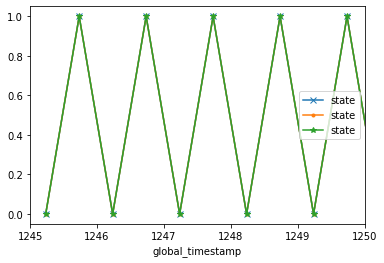

In [169]:
fig, ax = plt.subplots()

markers=['x', '.', '*']
for m, x in zip(markers, first_20.groupby('sig')):
    print(x[0])
    x[1].plot(x='global_timestamp', y='state', ax=ax, marker=m)
ax.set_xlim([1245, 1250])

In [93]:
rec_ev.set_index('global_timestamp', drop=True, inplace=True)

In [96]:
rec_ev

,channel,timestamp,processor_id,subprocessor_id,state,sig,is_edge
global_timestamp,,,,,,,
1245.233433,1,3113084,103,1,0,104,1
1245.733433,1,3114334,103,1,1,104,1
1246.233433,1,3115584,103,1,0,104,1
1246.733433,1,3116834,103,1,1,104,1
1247.233433,1,3118084,103,1,0,104,1
...,...,...,...,...,...,...,...
2417.236730,1,72528141,100,0,0,100,1
2417.736733,1,72532102,103,0,1,103,1
2417.736733,1,72543141,100,0,1,100,1


In [44]:
np.unique(rec0.events['processor_id']*10)

array([1000, 1030])

In [59]:
t_lf = (rec0.events[(rec0.events['processor_id']==103) & (rec0.events['subprocessor_id']==1)]['timestamp'])
t_ap = (rec0.events[(rec0.events['processor_id']==103) & (rec0.events['subprocessor_id']==0)]['timestamp'])
t_ad = (rec0.events[(rec0.events['processor_id']==100) & (rec0.events['subprocessor_id']==0)]['timestamp'])

In [60]:
sf_lf = (np.mean(np.diff(t_lf)*2))
sf_ap = (np.mean(np.diff(t_ap)*2))
sf_ad = (np.mean(np.diff(t_ad)*2))

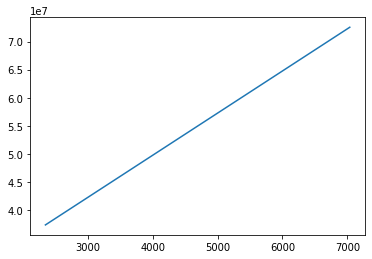

In [47]:
plt.plot(rec0.events[(rec0.events['processor_id']==103) & (rec0.events['subprocessor_id']==0)]['timestamp'])

In [61]:
rec = oe_epoch.recordnodes[0].recordings[0]

In [62]:
print(rec)

Open Ephys GUI Recording
ID: 0x7f09e3f77f10
Format: Binary
Directory: /mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-12/openephys/2021-06-12_13-16-57/Record Node 103/experiment1/recording1
Experiment Index: 0
Recording Index: 0


In [63]:
rec.info['continuous'][1]

{'folder_name': 'Neuropix-PXI-101.1/',
 'sample_rate': 2500,
 'source_processor_name': 'Neuropix-PXI',
 'source_processor_id': 101,
 'source_processor_sub_idx': 1,
 'recorded_processor': 'Record Node',
 'recorded_processor_id': 103,
 'num_channels': 384,
 'channels': [{'channel_name': 'LFP1',
   'description': 'Headstage data channel',
   'identifier': 'genericdata.continuous',
   'history': 'Neuropix-PXI -> Record Node',
   'bit_volts': 0.19499999284744263,
   'units': 'uV',
   'source_processor_index': 384,
   'recorded_processor_index': 384},
  {'channel_name': 'LFP2',
   'description': 'Headstage data channel',
   'identifier': 'genericdata.continuous',
   'history': 'Neuropix-PXI -> Record Node',
   'bit_volts': 0.19499999284744263,
   'units': 'uV',
   'source_processor_index': 385,
   'recorded_processor_index': 385},
  {'channel_name': 'LFP3',
   'description': 'Headstage data channel',
   'identifier': 'genericdata.continuous',
   'history': 'Neuropix-PXI -> Record Node',
   '

In [64]:
rec.info['events'][2]

{'folder_name': 'NI-DAQmx-105.0/TTL_1/',
 'channel_name': 'NI-DAQmx source TTL events input',
 'description': 'TTL Events coming from the hardware source processor "NI-DAQmx"',
 'identifier': 'sourceevent',
 'sample_rate': 30000,
 'type': 'int16',
 'num_channels': 8,
 'source_processor': 'NI-DAQmx'}

In [65]:
# this blows up i don't know why
# rec.add_sync_channel(0, 101, 0, main=True)
# rec.add_sync_channel(0, 101, 1, main=False)
# rec.add_sync_channel(0, 105, 0, main=False)
# rec.compute_global_timestamps()

In [26]:
files_pd = pd.DataFrame(sgl_files)

In [27]:
files_pd

,nidq,lf_0,ap_0
0,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...


In [28]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}


#probe_data_folder = sgl_folder['imec'][probe_id]


### view the nidaq data

In [29]:
run_recordings['nidq']

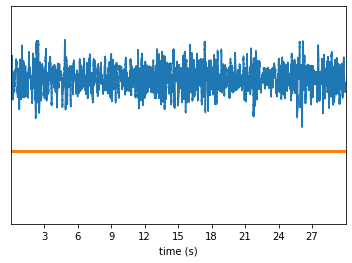

In [31]:
w_ts = sw.plot_timeseries(run_recordings['nidq'], channel_ids=[0, 1], trange=[0,30])

In [32]:
nidq_ttl = run_recordings['nidq'].get_ttl_events()

2021-06-13 13:02:53,773 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [154]:
run_recordings['ap_0']._raw.shape

(385, 414222418)

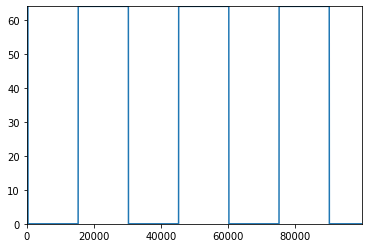

In [158]:
plt.plot(run_recordings['ap_0']._raw[-1,:100000])

In [159]:
ap_ups = np.where(np.diff(run_recordings['ap_0']._raw[-1,:])>0)

KeyboardInterrupt: 

In [ ]:
nidq_ttl = run_recordings['nidq']

In [34]:
syn_ch_arr = run_recordings['lf_0']._raw[-1, :]

np.mean(syn_ch_arr)

32.00300704573573

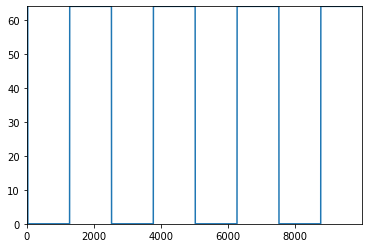

In [35]:
plt.plot(syn_ch_arr[:10000])

In [153]:
run_recordings['nidq']._meta

{'acqMnMaXaDw': '0,0,5,1',
 'appVersion': '20200520',
 'fileCreateTime': '2021-06-12T16:31:57',
 'fileName': 'C:/SGL_DATA/1631_g0/1631_g0_t0.nidq.bin',
 'fileSHA1': '42F8B1E8C56AC7A658FDE6294CF481F42A547A88',
 'fileSizeBytes': '3314139372',
 'fileTimeSecs': '13841.4861',
 'firstSample': '195677',
 'gateMode': 'Immediate',
 'nDataDirs': '1',
 'nSavedChans': '6',
 'niAiRangeMax': '5',
 'niAiRangeMin': '-5',
 'niAiTermination': 'RSE',
 'niClockLine1': 'Internal',
 'niClockSource': 'PXI1Slot4_8ch_Int : 20000.000000',
 'niDev1': 'PXI1Slot2',
 'niDev1ProductName': 'PXIe-6363',
 'niMAChans1': '',
 'niMAGain': '1',
 'niMNChans1': '',
 'niMNGain': '200',
 'niMuxFactor': '1',
 'niSampRate': '20000',
 'niStartEnable': 'false',
 'niStartLine': 'PXI1Slot2/port0/line0',
 'niXAChans1': '0:4',
 'niXDBytes1': '1',
 'niXDChans1': '0:7',
 'snsMnMaXaDw': '0,0,5,1',
 'snsSaveChanSubset': 'all',
 'syncNiChan': '0',
 'syncNiChanType': '0',
 'syncNiThresh': '1.1',
 'syncSourceIdx': '3',
 'syncSourcePeriod': '

In [36]:
run_recordings['ap_0']._meta

{'acqApLfSy': '384,384,1',
 'appVersion': '20200520',
 'fileCreateTime': '2021-06-12T16:31:57',
 'fileName': 'C:/SGL_DATA/1631_g0/1631_g0_imec0/1631_g0_t0.imec0.ap.bin',
 'fileSHA1': '83AA919E70BA977C4C54699CA61E5D860E39660A',
 'fileSizeBytes': '318951261860',
 'fileTimeSecs': '13841.712733333334',
 'firstSample': '293522',
 'gateMode': 'Immediate',
 'imAiRangeMax': '0.6',
 'imAiRangeMin': '-0.6',
 'imCalibrated': 'true',
 'imDatApi': '1.20',
 'imDatBs_fw': '1.1.123',
 'imDatBsc_fw': '1.0.151',
 'imDatBsc_hw': '5.1',
 'imDatBsc_pn': 'NP2_HS_30',
 'imDatBsc_sn': '567',
 'imDatFx_hw': '1.2',
 'imDatFx_pn': 'NP2_FLEX_0',
 'imDatHs_fw': '5.3',
 'imDatHs_pn': '',
 'imDatHs_sn': '3701768989021720654',
 'imDatPrb_pn': 'PRB_1_4_0480_1',
 'imDatPrb_port': '4',
 'imDatPrb_slot': '4',
 'imDatPrb_sn': '19108322052',
 'imDatPrb_type': '0',
 'imLEDEnable': 'false',
 'imMaxInt': '512',
 'imRoFile': 'D:/imro/lf_500x_extref.imro',
 'imSampRate': '30000',
 'imStdby': '',
 'imTrgRising': 'true',
 'imTrgS

## The digital and sync channel in the recording
- using the new methods in my version of readSGLX, spikeglxrecordingextractor

2021-06-13 13:06:42,039 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


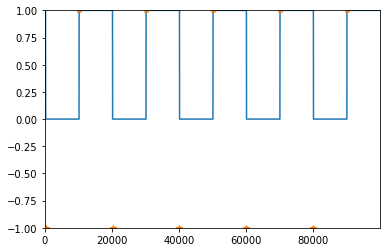

In [37]:
### the digital chan and the syn extraction of the nidq rec

nidq_syn = rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, 100000, 0, [0], run_recordings['nidq']._meta)
nidq_syn_ttl = run_recordings['nidq'].get_ttl_events(channel_id=0, end_frame=100000)

plt.plot(nidq_syn.flatten())
plt.plot(*nidq_syn_ttl, '*')

In [151]:
run_recordings['nidq']._meta

{'acqMnMaXaDw': '0,0,5,1',
 'appVersion': '20200520',
 'fileCreateTime': '2021-06-12T16:31:57',
 'fileName': 'C:/SGL_DATA/1631_g0/1631_g0_t0.nidq.bin',
 'fileSHA1': '42F8B1E8C56AC7A658FDE6294CF481F42A547A88',
 'fileSizeBytes': '3314139372',
 'fileTimeSecs': '13841.4861',
 'firstSample': '195677',
 'gateMode': 'Immediate',
 'nDataDirs': '1',
 'nSavedChans': '6',
 'niAiRangeMax': '5',
 'niAiRangeMin': '-5',
 'niAiTermination': 'RSE',
 'niClockLine1': 'Internal',
 'niClockSource': 'PXI1Slot4_8ch_Int : 20000.000000',
 'niDev1': 'PXI1Slot2',
 'niDev1ProductName': 'PXIe-6363',
 'niMAChans1': '',
 'niMAGain': '1',
 'niMNChans1': '',
 'niMNGain': '200',
 'niMuxFactor': '1',
 'niSampRate': '20000',
 'niStartEnable': 'false',
 'niStartLine': 'PXI1Slot2/port0/line0',
 'niXAChans1': '0:4',
 'niXDBytes1': '1',
 'niXDChans1': '0:7',
 'snsMnMaXaDw': '0,0,5,1',
 'snsSaveChanSubset': 'all',
 'syncNiChan': '0',
 'syncNiChanType': '0',
 'syncNiThresh': '1.1',
 'syncSourceIdx': '3',
 'syncSourcePeriod': '

In [128]:
nidq_sf = run_recordings['nidq'].get_effective_sf()

In [129]:
nidq_sf

(19999.131363603447,
 array([0.00000000e+00, 5.00021717e-05, 1.00004343e-04, ...,
        1.38095137e+04, 1.38095137e+04, 1.38095138e+04]),
 (array([      214,     10214,     20214, ..., 276161443, 276171443,
         276174995]),
  array([-1,  1, -1, ...,  1, -1,  1])))

In [125]:
ap_sf = run_recordings['ap_0'].get_effective_sf()

In [130]:
ap_sf

(30000.25,
 array([0.00000000e+00, 3.33330556e-05, 6.66661111e-05, ...,
        1.38072988e+04, 1.38072988e+04, 1.38072988e+04]),
 (array([   325,  15324,  30326,  45325,  60326,  75325,  90326, 105325,
         120326, 135325]),
  array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1])))

In [ ]:
run_recordings['ap_0'].get_effective_sf

In [ ]:
run_recordings['ap_0'].get_effective_sf

In [38]:
nidq_syn_ttl

(array([  214, 10214, 20214, 30214, 40214, 50214, 60213, 70213, 80213,
        90213]),
 array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1]))

In [150]:
np.mean(np.diff(nidq_syn_ttl[0],1))

9999.888888888889

In [145]:
np.mean(np.diff(ap_syn_ttl[0]))

15000.0

In [141]:
214/325

0.6584615384615384

In [142]:
nidq_sf[0]/ap_sf[0]

0.6666321568521412

2021-06-15 02:07:46,639 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-15 02:07:46,640 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (150007,)
2021-06-15 02:07:46,643 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00362649743012
2021-06-15 02:07:46,646 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-06-15 02:07:46,647 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-15 02:07:46,647 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (150007,)
2021-06-

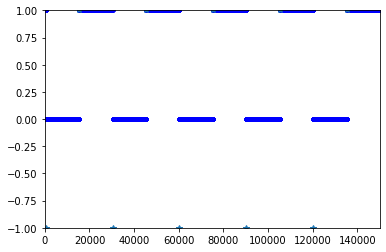

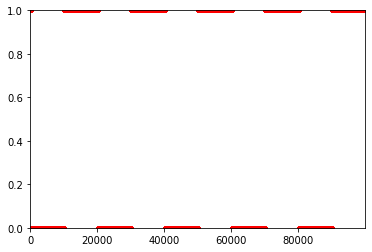

In [140]:
### the digital chan and the syn extraction of the nidq rec
end_frame = int(100000*ap_sf[0]/nidq_sf[0])

ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, end_frame, 0, [0], run_recordings['ap_0']._meta)
ap_syn_ttl = run_recordings['ap_0'].get_ttl_events(end_frame=end_frame)

plt.plot(ap_syn.flatten(), 'b.')
plt.plot(*ap_syn_ttl, '*')
plt.figure()
plt.plot(nidq_syn.flatten(), 'r.')

In [137]:
ap_syn.flatten()

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [138]:
nidq_syn.flatten()

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [40]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/1631_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-12/1631_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-12/sglx/1631_g0',
  'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-12/1631_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-12/sglx/1631_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-12/sglx/1631_g0',
  'tmp': '/scratch/earneodo/tmp/1631_g0',
  'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-12/1631_g0',
  'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-12/1631_g0'},
 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-12/1631_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-12/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-12/sglx/rig.json',
  'kwd': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-12/1631_g0/stream.kw

##### get the microphone channel

In [170]:
from ceciestunepipe.util.sound import spectral as sp
from scipy.io import wavfile

In [173]:
rec0.continuous[2].metadata

{'sample_rate': 30000,
 'num_channels': 8,
 'processor_id': 100,
 'subprocessor_id': 0,
 'names': ['ADC1', 'ADC2', 'ADC3', 'ADC4', 'ADC5', 'ADC6', 'ADC7', 'ADC8']}

In [178]:
# quick and dirty
mic_continous_idx = 2
mic_chan_id = [0]


mic_continous = rec0.continuous[mic_continous_idx]
mic_s_f = rec0.continuous[mic_continous_idx]

mic_stream = mic_continous.samples[:, mic_chan_id]

In [181]:
mic_continous.samples

memmap([[   267, -25785, -31397, ..., -31249, -30184, -14885],
        [   283, -25783, -31399, ..., -31251, -30186, -14885],
        [   279, -25777, -31391, ..., -31241, -30177, -14877],
        ...,
        [   295,   -431, -25269, ..., -31807, -29424, -15141],
        [   283,   -437, -25282, ..., -31819, -29437, -15155],
        [   279,   -453, -25290, ..., -31827, -29445, -15161]],
       dtype=int16)

In [182]:
mic_continous.samples.shape

(35209728, 8)

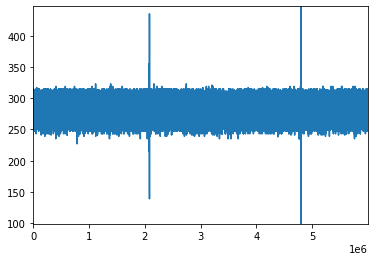

In [187]:
plt.plot(mic_continous.samples[:6000000, 0])

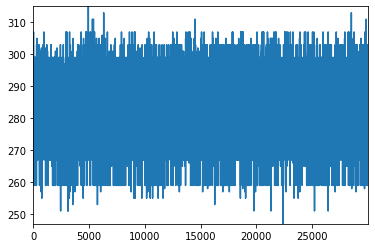

In [183]:
plt.plot(mic_stream[:30000])

In [45]:
s_f = run_recordings['nidq'].get_effective_sf()[0]

In [46]:
run_recordings['nidq']._s_f_0

19999.75

In [47]:
s_f

19999.75

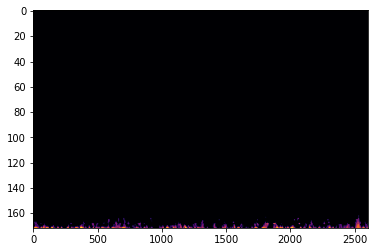

In [48]:
reload(sp)
f, t, s = sp.ms_spectrogram(mic_stream[0, 300000:350000], s_f)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [51]:
mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
mic_file_name

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-12/sglx/1631_g0/wav_mic.wav'

In [53]:
def mic_to_wav(recording_extractor, mic_chan_list: list, wav_path:str):
    # get the stream
    mic_stream = recording_extractor.get_traces(channel_ids=mic_chan_list)
    # make sure folder exists
    logger.info('saving {}-shaped array as wav in {}'.format(mic_stream.shape, wav_path))
    os.makedirs(os.path.split(wav_path)[0], exist_ok=True)
    # write it
    s_f = int(round(recording_extractor.get_sampling_frequency()/1000))*1000
    logger.info('sampling rate {}'.format(s_f))
    wavfile.write(wav_path, s_f, mic_stream.T)
    
    ## also save as numpy
    npy_path = wav_path.split('.')[0] + '.npy'
    logger.info('saving {}-shaped array as npy in {}'.format(mic_stream.shape, npy_path))
    np.save(npy_path, mic_stream.T)
    
mic_to_wav(run_recordings['nidq'], mic_chan_id, mic_file_name)

2021-06-13 13:14:11,981 root         INFO     saving (1, 276178281)-shaped array as wav in /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-12/sglx/1631_g0/wav_mic.wav
2021-06-13 13:14:11,997 root         INFO     sampling rate 20000
2021-06-13 13:14:13,203 root         INFO     saving (1, 276178281)-shaped array as npy in /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-12/sglx/1631_g0/wav_mic.npy


#### match_template

In [34]:
## I see in the wav there is a bout starting in 354.64 (5 motifs)
## also in 13871.53 (6 motifs)


In [40]:
s_f
n_window = 256

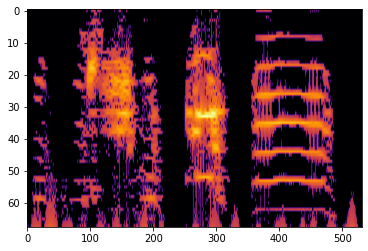

In [41]:
temp_start_sample = int(357.43 * s_f)
temp_end_sample = temp_start_sample + int(s_f*0.52)

template1 = mic_stream[0, temp_start_sample: temp_end_sample]

f, t, s1 = sp.ms_spectrogram(template1, s_f, n_window)

#plt.plot(template)
plt.imshow(np.log(s1[::-1]), aspect='auto', cmap='inferno')

In [42]:
s1.shape

(68, 531)

### The time syncronization

In [68]:
# t_0 is n/s_f (measured s_f)
# t_prime is interpolation to a t_ref (the nidaq, for instance, but it should be the one with the highest s_f)

In [54]:
def compute_sf(ttl: tuple) -> np.array:
    ttl_arr = np.array(ttl)
    
    # get all the diffs betwenn edge ups and edge donws
    all_diff_arr = np.concatenate([np.diff(ttl_arr[0, ttl_arr[1]==j]) for j in [-1, 1]])
    
    return all_diff_arr

np.mean(compute_sf(ap_syn_ttl))

30000.4

In [55]:
compute_sf(nidq_syn_ttl)

array([20000, 20000, 19999, 20000, 20000, 20000, 19999, 20000])

#### use the imec af as a pattern

In [56]:
signal = 'ap_0'

syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 120000, 0, [0], run_recordings[signal]._meta)

traces = run_recordings[signal].get_traces(end_frame=120000)
n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=120000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-06-13 13:21:14,594 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-13 13:21:14,596 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (120000,)
2021-06-13 13:21:14,601 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00213333333333
2021-06-13 13:21:14,605 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-06-13 13:21:14,606 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-13 13:21:14,607 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (120000,)
2021-06-

### debug the sync

In [86]:
ttl_ap = run_recordings['ap_0'].get_ttl_events()
ttl_nidq = run_recordings['nidq'].get_ttl_events()

2021-06-14 19:34:56,329 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-06-14 19:34:56,334 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-14 19:34:56,491 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (414222418,)
2021-06-14 20:22:49,374 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.0015714842358
2021-06-14 20:24:34,119 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [92]:
ttl_ap[]

(array([      325,     15324,     30326, ..., 414191618, 414206619,
        414220661]),
 array([-1,  1, -1, ...,  1, -1,  1]))

In [112]:
run_recordings['ap_0']._timeseries.shape

(384, 414222418)

In [114]:
run_recordings['nidq']._timeseries.shape

(6, 276178281)

In [118]:
ttl_ap[1]

array([-1,  1, -1, ...,  1, -1,  1])

In [116]:
ttl_ap[0].reshape([-1,2])

array([[      325,     15324],
       [    30326,     45325],
       [    60326,     75325],
       ...,
       [414146619, 414161618],
       [414176619, 414191618],
       [414206619, 414220661]])

In [108]:
np.unique(np.diff(ttl_ap[0].reshape([-1,2])))

array([10104, 14042, 14999, 15000])

In [109]:
np.unique(np.diff(ttl_nidq[0].reshape([-1,2])))

array([ 3552,  4998,  9999, 10000])

In [103]:
np.where(ttl_ap[1].reshape([-1,2]).sum(axis=1)>0)

(array([], dtype=int64),)

In [104]:
np.where(ttl_nidq[1].reshape([-1,2]).sum(axis=1)>0)

(array([], dtype=int64),)

In [94]:
ttl_nidq

(array([      214,     10214,     20214, ..., 276161443, 276171443,
        276174995]),
 array([-1,  1, -1, ...,  1, -1,  1]))

In [90]:
ttl_nidq[1].shape

(27620,)

In [57]:
ttl_edge_tuple_pattern = ttl_edge_tuple
s_f_pattern = s_f
t_pattern = t_0
t_pattern_edge = t_0_edge
syn_stream_pattern = syn_stream

In [58]:
#plt.plot(t_0_edge, np.ones_like(t_0_edge), '*')

In [59]:
s_f_pattern, t_pattern, ttl_edge_tuple_pattern = run_recordings[signal].get_effective_sf()

In [60]:
ttl_edge_tuple_pattern[0].shape

(8,)

#### fit the nidaq to the pattern

In [61]:
signal = 'nidq'
traces = run_recordings[signal].get_traces(end_frame=100000)
syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 100000, 0, [0], run_recordings[signal]._meta)

n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=100000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-06-13 13:21:28,182 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [62]:
run_recordings[signal].syn_to_pattern(t_pattern, ttl_edge_tuple_pattern)

ValueError: Number of edges in the syn ttl events of pattern and target dont match

### make the time conversions using the syn_to_sgl_rec_exctractor method

In [63]:
run_recordings['lf_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-06-13 13:21:49,650 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-06-13 13:21:49,651 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-13 13:21:49,653 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (414222418,)
2021-06-13 13:56:27,826 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.0015714842358
2021-06-13 13:56:38,448 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-06-13 13:56:38,451 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an

ValueError: Number of edges in the syn ttl events of pattern and target dont match

In [85]:
run_recordings['nidq'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-06-14 17:15:46,052 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-06-14 17:15:46,122 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-14 17:15:46,195 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (414222418,)
2021-06-14 18:02:56,273 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.0015714842358
2021-06-14 18:52:07,570 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


ValueError: Number of edges in the syn ttl events of pattern and target dont match

In [80]:
run_recordings['ap_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-06-05 03:23:41,303 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-06-05 03:23:41,305 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-05 03:23:41,306 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (419544542,)
2021-06-05 04:11:04,973 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00253257495601
2021-06-05 05:07:41,287 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-06-05 05:07:41,289 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from a

### plot the square syn signals in the three different timescales

In [81]:
# sig = 'lf_0'
# t_start_plot = 125

# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

# sig = 'ap_0'
# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

# sig = 'nidq'
# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

## Save the mot_dict data

In [82]:
mot_dict_path = os.path.join(exp_struct['folders']['processed'], 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(mot_dict, handle)

In [110]:
mot_dict_path

'/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201106/dir_g0/mot_dict.pkl'

### The sorting

In [64]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxoneextractors.maxoneextractors.MaxOneRecordingExtractor,
 spikeextractors.extractors.mea1kextractors.mea1kextractors.Mea1kRecordingExtractor,
 spikeextractors.extractors.mcsh5recordingextractor.mcsh5rec

##### pick one ap stream, view it after running some of the toolkits

In [65]:
ap_extractor = run_recordings['ap_0']

###### view it raw

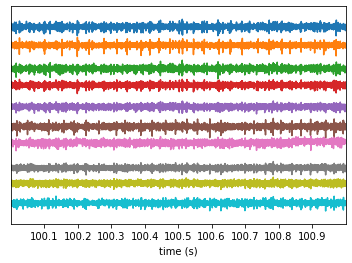

In [71]:
sw.plot_timeseries(ap_extractor, channel_ids=range(60, 70), trange=[100,101])

###### filtered

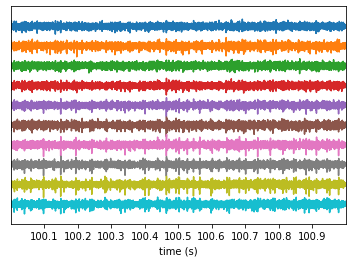

In [72]:
ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[100,101])

###### cmr

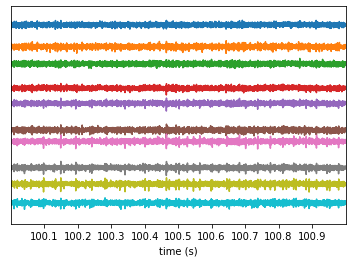

In [74]:
ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(40, 50), trange=[100,101])

In [75]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/1631_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-12/1631_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-12/sglx/1631_g0',
 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-12/1631_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-12/sglx/1631_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-12/sglx/1631_g0',
 'tmp': '/scratch/earneodo/tmp/1631_g0',
 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-12/1631_g0',
 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-12/1631_g0'}

In [76]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

In [77]:
def run_spikesort(recording_extractor: se.RecordingExtractor, 
                  logger: logging.Logger,
                  sort_pickle_path: str,
                  tmp_dir: str, 
                  grouping_property: str=None,
                 sorting_method: str='kilosort2',
                 n_jobs_bin: int=N_JOBS_MAX,
                 chunk_mb: int=4096, restrict_to_gpu=None,
                 **sort_kwargs):

    logger.info("Grouping property: {}".format(grouping_property))
    logger.info("sorting method: {}".format(sorting_method))
    
    # try:
    if sorting_method == "kilosort2":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks2')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

            
        sort = ss.run_kilosort2(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            n_jobs_bin=n_jobs_bin,
            **sort_kwargs
        )
        
    else:
        raise NotImplementedError('Only know how to sort kilosort2 for now, \
                                        will deal with {} later'.format(sorting_method))
        
    logger.info('done sorting')
    
    # save sort
    logger.info("Saving sort {}".format(sort_pickle_path))
    with open(sort_pickle_path, "wb") as output:
        pickle.dump(sort, output, pickle.HIGHEST_PROTOCOL)
    logger.info("Sorting output saved to {}".format(sort_pickle_path))
      
#     # get templates and max channel
#     logger.info("Getting templates")
#     templates = st.postprocessing.get_unit_templates(
#         recording_extractor,
#         sort,
#         max_spikes_per_unit=200,
#         save_as_property=True,
#         verbose=True,
#         n_jobs=n_jobs_bin,
#         grouping_property=grouping_property,
#     )
    
#     logger.info("Getting main channel")
#     max_chan = st.postprocessing.get_unit_max_channels(
#         recording_extractor, 
#         sort, 
#         save_as_property=True, 
#         verbose=True, 
#         n_jobs=n_jobs_bin
#     )   
    
    # save sort again with all that processed data
    sort_temp_pickle_path = sort_pickle_path + '.dump.pkl'
    logger.info("Saving sort {}".format(sort_temp_pickle_path))
    sort.dump_to_pickle(sort_temp_pickle_path)
    
    return sort

In [78]:
ss.__version__

'0.4.3'

In [79]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [80]:
default_ks2_params = ss.Kilosort2Sorter.default_params()
default_ks2_params

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [81]:
1/100

0.01

##### manually enter ksort params

In [82]:
ks2_params = {'minFR': 0.01,
             'minfr_goodchannels': 0.01}

In [83]:
tmp_loc = exp_struct['folders']['ksort']
tmp_loc

'/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-12/1631_g0'

In [84]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle')

sort = run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

2021-06-13 15:37:23,206 root         INFO     Grouping property: None
2021-06-13 15:37:23,207 root         INFO     sorting method: kilosort2
2021-06-13 15:37:23,208 root         INFO     Sorting tmp dir /scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-12/1631_g0/tmp_ks2
2021-06-13 15:37:23,209 root         INFO     Will set visible gpu devices 1


kilosort2 run time 9722.00s


2021-06-13 18:28:14,606 root         INFO     done sorting
2021-06-13 18:28:14,609 root         INFO     Saving sort /scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-12/1631_g0/sort_ks2.pickle
2021-06-13 18:28:33,588 root         INFO     Sorting output saved to /scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-12/1631_g0/sort_ks2.pickle
2021-06-13 18:28:33,590 root         INFO     Saving sort /scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-12/1631_g0/sort_ks2.pickle.dump.pkl


### load the sort

In [104]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#sort_pickle_path

In [105]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#print(sort_pickle_path)
#loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

In [106]:
### load the sort directly from kilosort npy files
from ceciestunepipe.util.spike import kilosort as ks

In [107]:
reload(ks)

<module 'ceciestunepipe.util.spike.kilosort' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py'>

In [113]:
!ls /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201106/2500r250a_3500_dir_g0/tmp_ks2/

ls: cannot access '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201106/2500r250a_3500_dir_g0/tmp_ks2/': No such file or directory


### plot a raster

In [114]:
mot_dict

{'template': memmap([5987, 5932, 5963, ..., 7721, 7777, 7734], dtype=int16),
 's_f': 25000,
 's_f_nidq': 24999.833333333332,
 's_f_ap_0': 30000.0,
 'start_ms': array([  356895.37930253,   357430.38286922,   357957.38638258,
          358487.38991593,   359338.3955893 , 12273836.82557884,
        12274374.82916553, 12275240.8349389 , 12275786.83857892,
        13873757.49171661, 13874300.49533664, 13874843.49895666,
        13875599.50399669, 13876145.50763672, 13877018.51345676]),
 'start_sample_naive': array([  8922325,   8935700,   8948875,   8962125,   8983400, 306843875,
        306857325, 306878975, 306892625, 346841625, 346855200, 346868775,
        346887675, 346901325, 346923150]),
 'start_sample_nidq': array([  8922326,   8935700,   8948876,   8962126,   8983401, 306843876,
        306857326, 306878976, 306892626, 346841626, 346855201, 346868775,
        346887676, 346901326, 346923151]),
 'start_t_0': array([  356.8954193 ,   357.43038287,   357.95742638,   358.48742992,
    

In [115]:
# samples in nidq stream
# corresponding times in nidq stream tprime
nidq_samples = mot_dict['start_sample_nidq']
nidq_samples = mot_dict['start_sample_naive']

t_mot_prime = run_recordings['nidq']._t_prime[nidq_samples]

t_pre = -0.5
t_post = 1.5

t_range_arr = np.vstack([t_mot_prime + t_pre, t_mot_prime + t_post]).T

t_range_arr

array([[  356.39705244,   358.39705244],
       [  356.93210924,   358.93210924],
       [  357.45908816,   359.45908816],
       [  357.9891182 ,   359.9891182 ],
       [  358.84010815,   360.84010815],
       [12273.39693353, 12275.39693353],
       [12273.93493481, 12275.93493481],
       [12274.80095487, 12276.80095487],
       [12275.34694471, 12277.34694471],
       [13873.3255195 , 13875.3255195 ],
       [13873.8685622 , 13875.8685622 ],
       [13874.41155362, 13876.41155362],
       [13875.16756978, 13877.16756978],
       [13875.713562  , 13877.713562  ],
       [13876.58656048, 13878.58656048]])

In [116]:
t0_naive

array([  356.8953793 ,   357.43038287,   357.95738638,   358.48738992,
         359.33839559, 12273.83682558, 12274.37482917, 12275.24083494,
       12275.78683858, 13873.75749172, 13874.30049534, 13874.84349896,
       13875.599504  , 13876.14550764, 13877.01851346])

### Visualize a bout together with the neural traces

In [117]:
t_start = t0_naive

In [118]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu

In [119]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [131]:
hvc_chans = list(range(290, 324)) #HVC
ra_chans = list(range(50, 101)) #RA

neur_chans = hvc_chans + ra_chans
neur_chans = hvc_chans

mot_start_ms = 356895 # in nidq time
#mot_start_ms = 7619983

pre_sec = -2.25
post_sec = 4 - pre_sec

# get coincident starts in samples
# the nidq from the time, then convert that time to t_prime
nidq_start = np.where(run_recordings['nidq']._t_prime > mot_start_ms*0.001)[0][0]
t_prime_start = run_recordings['nidq']._t_prime[nidq_start]
nidq_sf = run_recordings['nidq']._s_f_0

# the ap sample from the t_prime
ap_start = np.where(run_recordings['ap_0']._t_0 > t_prime_start)[0][0]
ap_sf = run_recordings['ap_0']._s_f_0

mic_arr = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id, 
                                            start_frame=nidq_start + pre_sec*nidq_sf, 
                                            end_frame=nidq_start + post_sec*nidq_sf)


ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=ap_start + pre_sec*ap_sf, 
                                            end_frame=ap_start + post_sec*ap_sf)

In [132]:
ap_start + pre_sec*ap_sf

10639351.99098938

In [133]:
ap_sf

30000.00400471985

<ipython-input-134-dcd387bbf1c8>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')


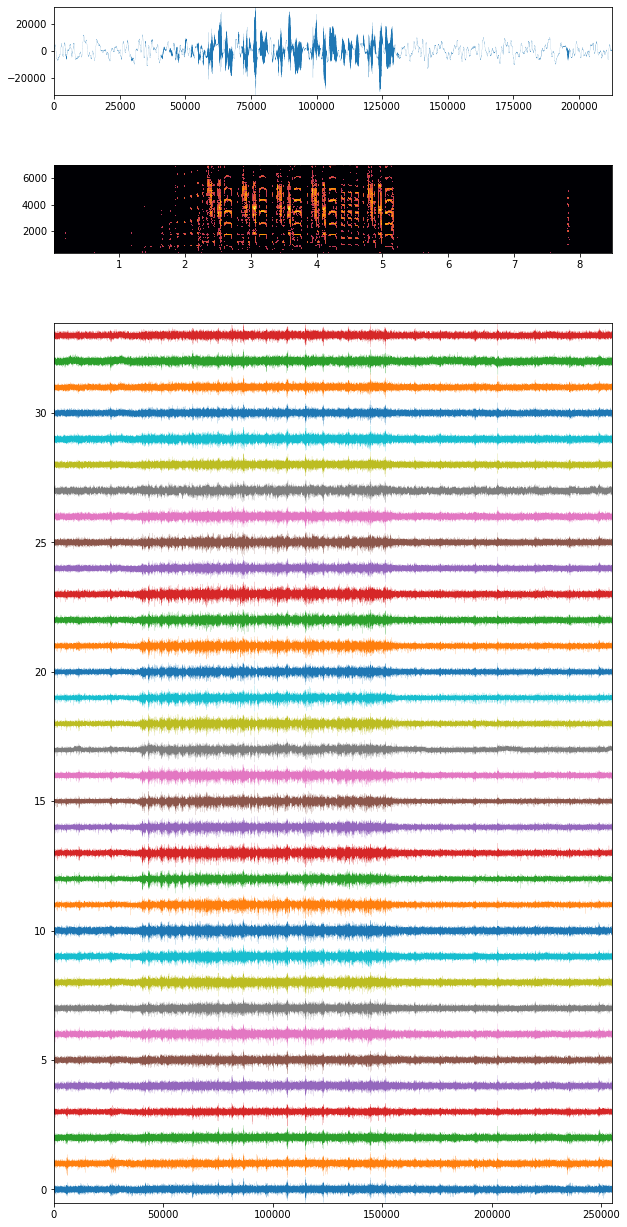

In [134]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

### load the spikes

In [135]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks2'))
spk_df.head(1)

,times,clusters
0,122,289


In [136]:
## call the HVC/RA sites
clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

### save to pickle
spike_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [137]:
clu_df.head(1)

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
243,243,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[12, 10, 11, 14, 13, 16, 15, 8, 7, 9, 18, 6, 4...",12,"[10, 11, 12, 13, 14, 15, 16]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


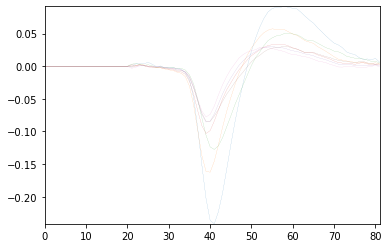

In [138]:
plt.plot(clu_df.loc[0, 'main_wav_7']);

### get motif alinged rasters

In [139]:
## use the starts in mot_dict start sample to get the t_prime
## get the samples for t_prime in the ap channel
## get those spikes

start_t_nidq = mot_dict['start_t_0']

mot_dict['start_t_ap_0'] = run_recordings['nidq']._t_prime[mot_dict['start_sample_nidq']]

mot_start_ap_samples = np.array([np.where(run_recordings['ap_0']._t_prime > start)[0][0] for start in mot_dict['start_t_ap_0']])

mot_dict['start_sample_ap_0'] = mot_start_ap_samples

In [140]:
run_recordings['ap_0']._s_f_0

30000.00400471985

#### check alignment of the syn signals

In [141]:
n_samples_ap = run_recordings['ap_0'].get_traces().shape[-1]
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, n_samples_ap, 0, [0], run_recordings['ap_0']._meta)

n_samples_nidq = run_recordings['nidq'].get_traces().shape[-1]
nidq_syn= rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, n_samples_nidq, 0, [0], run_recordings['nidq']._meta).flatten()

2021-06-06 09:30:44,387 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-06 09:30:44,389 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (419544542,)
2021-06-06 10:49:51,398 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00253257495601


In [142]:
mot_dict

{'template': memmap([5987, 5932, 5963, ..., 7721, 7777, 7734], dtype=int16),
 's_f': 25000,
 's_f_nidq': 24999.833333333332,
 's_f_ap_0': 30000.0,
 'start_ms': array([  356895.37930253,   357430.38286922,   357957.38638258,
          358487.38991593,   359338.3955893 , 12273836.82557884,
        12274374.82916553, 12275240.8349389 , 12275786.83857892,
        13873757.49171661, 13874300.49533664, 13874843.49895666,
        13875599.50399669, 13876145.50763672, 13877018.51345676]),
 'start_sample_naive': array([  8922325,   8935700,   8948875,   8962125,   8983400, 306843875,
        306857325, 306878975, 306892625, 346841625, 346855200, 346868775,
        346887675, 346901325, 346923150]),
 'start_sample_nidq': array([  8922326,   8935700,   8948876,   8962126,   8983401, 306843876,
        306857326, 306878976, 306892626, 346841626, 346855201, 346868775,
        346887676, 346901326, 346923151]),
 'start_t_0': array([  356.8954193 ,   357.43038287,   357.95742638,   358.48742992,
    

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

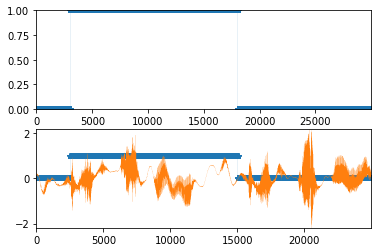

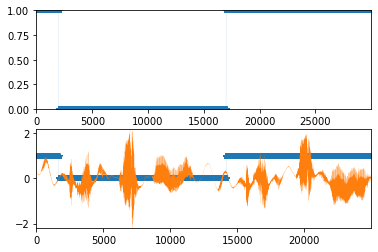

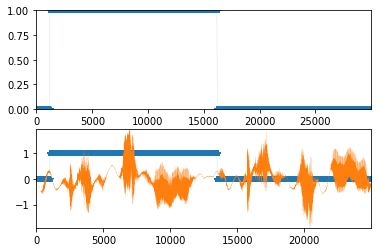

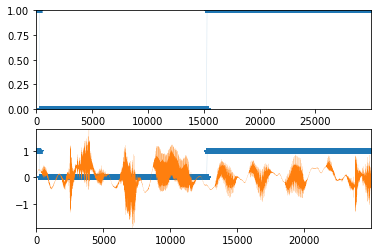

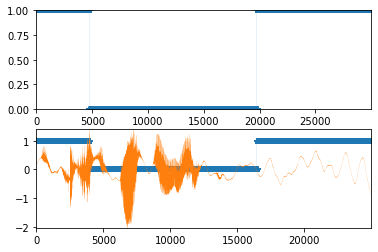

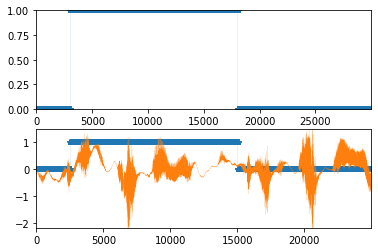

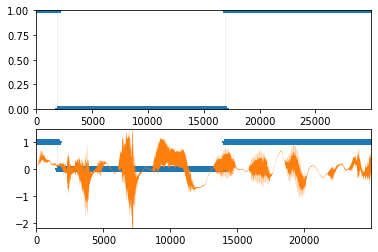

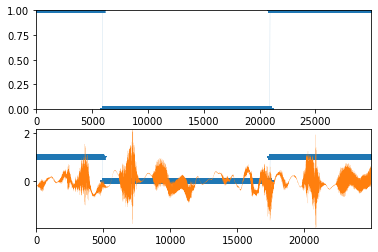

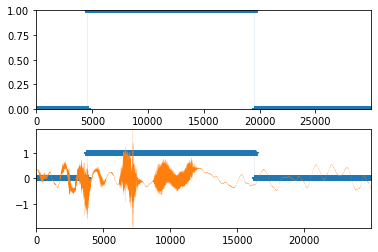

In [143]:
mot_idx = 8
sec_before = 0
sec_after = 1

for mot_idx in range(9):
    start_ap = mot_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_before)
    end_ap = mot_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_after)

    start_nidq = mot_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_before)
    end_nidq = mot_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_after)

    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(ap_syn[start_ap: end_ap], '-*')
    ax[1].plot(nidq_syn[start_nidq: end_nidq], '-*')
    ax[1].plot(mic_stream[0, start_nidq: end_nidq]/15000)

In [154]:
mot_dict['start_sample_ap_0'] + t_pre_samp

NameError: name 't_pre_samp' is not defined

In [155]:
mot_dict['start_sample_ap_0'] + t_post_samp

NameError: name 't_post_samp' is not defined

In [147]:
## get the actural raster for some clusters
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)
    
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

t_pre = - 0.5
t_post = 1.5

s_f_ap = run_recordings['ap_0']._s_f_0
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)

#spk_arr = get_window_spikes(spk_df, clu_list, ap_samples[0] + t_pre_samp, ap_samples[0] + t_post_samp)


rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

<ipython-input-148-2c44d1ee4803>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')


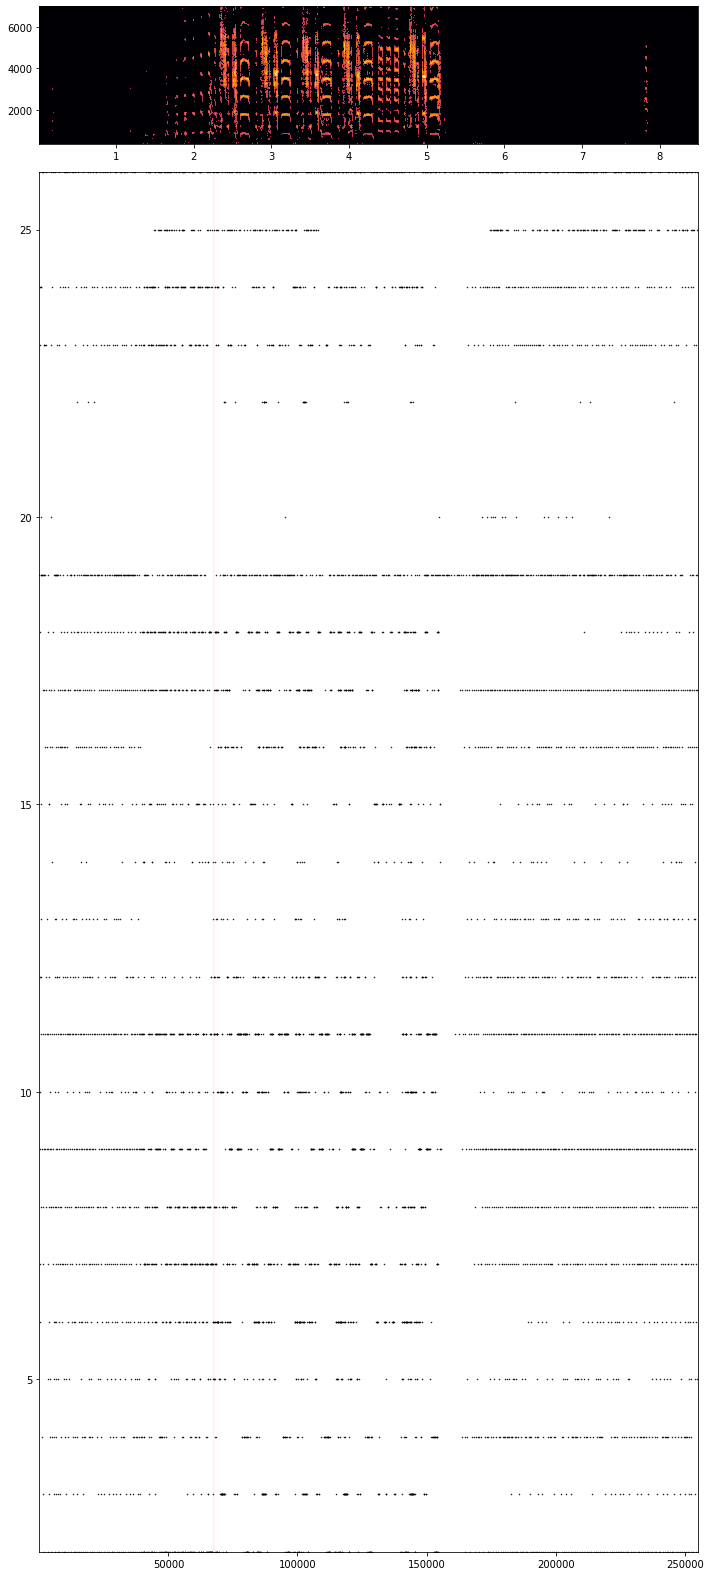

In [148]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[1])
plt.tight_layout()

IndexError: index 25 is out of bounds for axis 0 with size 25

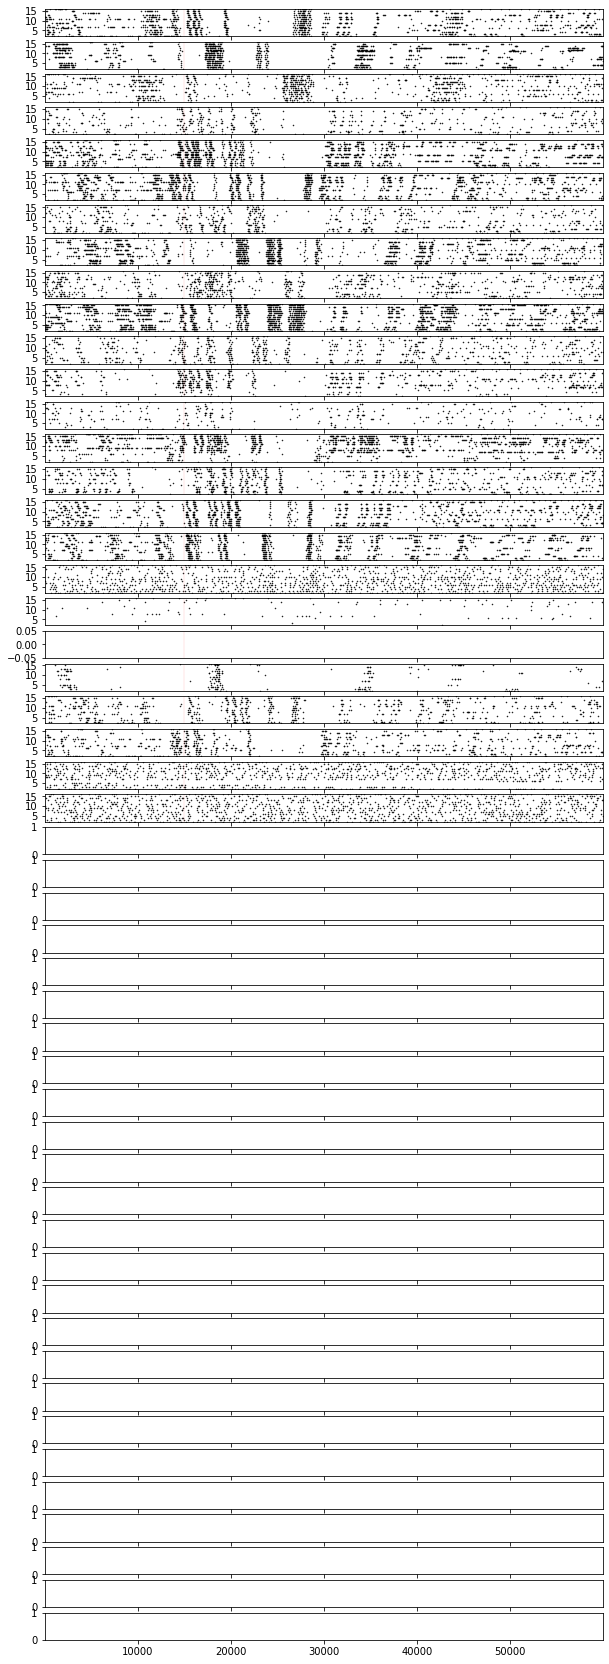

In [151]:
#### plot 50 rasters
fig, ax_arr = plt.subplots(nrows=50, figsize=[10, 30], sharex=True)

for i_rast, clu_idx in enumerate(range(0, 50)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    plot_as_raster(rast_arr[clu_idx].T, t_0=-t_pre_samp, ax=ax_arr[i_rast])

In [161]:
fig_path = os.path.join(exp_struct['folders']['processed'], 'rasters_0')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

In [162]:
fig_path

'/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/rasters_0'

In [163]:
spk_arr.shape

(169, 375001)

In [164]:
fig_path = os.path.join(exp_struct['folders']['processed'], 'bout_raster_1')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

In [165]:
fig_path

'/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/bout_raster_1'

In [166]:
clu_df.head(1)

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
0,0,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 1, 3, 4, 5, 23, 25, 21, 24, 18, 17, 10,...",0,"[0, 1, 2, 3, 4, 5, 23]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [ ]:
clu_df.

In [167]:
clu_nuclei = clu_df.loc[clu_df['cluster_id'].isin(clu_list), 'nucleus'].values
clu_nuclei

array(['ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra', 'ra',
       'ra', 'ra', 'hvc', 'hvc', 'hvc', 'hvc', 'hvc

In [168]:
ra_clu_idx = np.where(clu_nuclei=='ra')
hvc_clu_idx = np.where(clu_nuclei=='hvc')


In [169]:
hvc_clu_idx

(array([145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]),)

In [170]:
clu_list

array([ 170,  176,  179,  180,  181,  182,  183,  184,  186,  187,  188,
        189,  190,  191,  194,  197,  198,  199,  200,  204,  205,  206,
        208,  210,  211,  212,  214,  215,  217,  218,  219,  221,  226,
        229,  230,  232,  233,  236,  237,  238,  239,  242,  243,  244,
        245,  249,  253,  254,  255,  256,  259,  261,  262,  263,  264,
        266,  269,  270,  271,  272,  275,  276,  277,  278,  279,  280,
        281,  284,  286,  287,  288,  289,  290,  293,  294,  300,  301,
        302,  303,  304,  306,  307,  308,  309,  313,  314,  316,  317,
        318,  319,  320,  322,  323,  326,  327,  328,  331,  333,  334,
        335,  336,  337,  338,  340,  342,  343,  344,  345,  346,  347,
        348,  727,  731,  732,  734,  735,  739,  740,  741,  742,  746,
        747,  757,  762,  777,  778,  782,  783,  854,  855,  857,  858,
        859,  860,  862,  864,  865,  868,  869,  871,  872,  874,  875,
        876,  877,  878,  879,  880,  984,  985,  9

In [171]:
reload(pu)

<module 'ceciestunepipe.util.plotutil' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py'>

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = exploded_x.mean(axis=-1)
<ipython-input-160-a7072cf94595>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:282: RuntimeWarning: divide by zero encountered in true_divide
  x_scaled = plottable_array(x, 1./ptp, offset)
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:253: RuntimeWarning: invalid value encountered in double_scalars
  x[row, col] = (x[row, col] - col_mean)* scale[col] + offset[col]


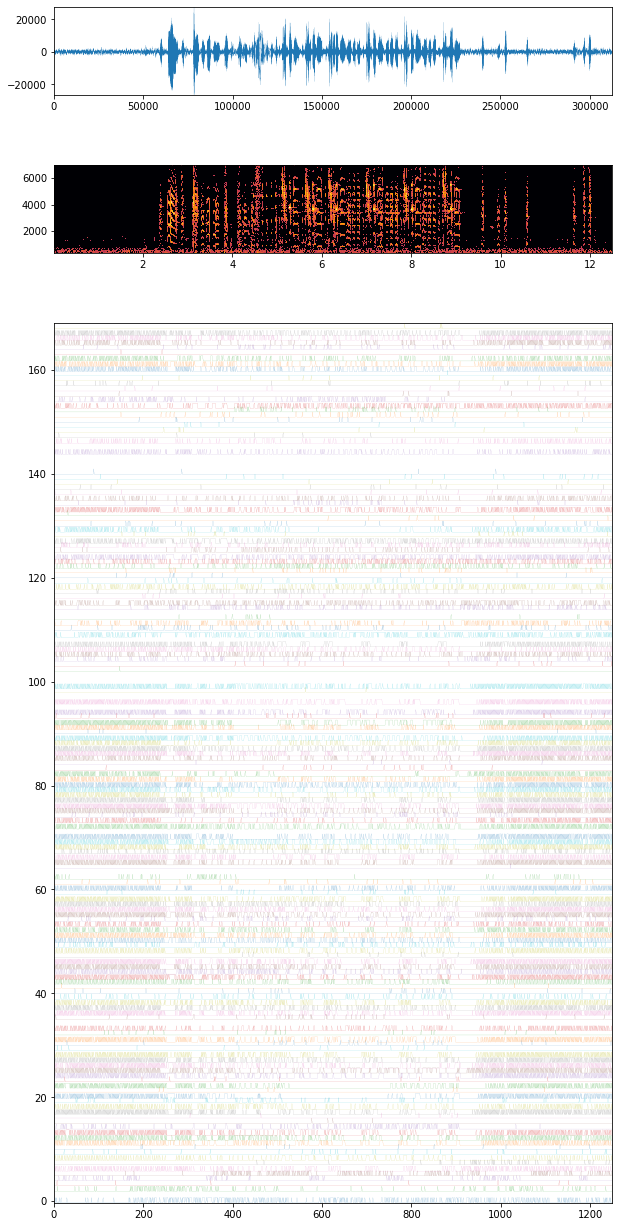

In [160]:
# make 5ms bins and count spikes
bin_size_samples = 300

bin_spk_arr = pu.coarse(spk_arr.astype(np.float), bin_size_samples)
np.nan_to_num(bin_spk_arr, 0)

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(bin_spk_arr.T.astype(np.float), ax=ax[2])

### save cluster, motif and cluster metadata

In [172]:
import pickle

In [173]:
clu_df_path = os.path.join(exp_struct['folders']['processed'], 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['processed'], 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(exp_struct['folders']['processed'], 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(mot_dict, handle)


In [174]:
exp_struct['folders']['processed']

'/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0'

In [161]:
bin_spk_arr.shape

(169, 1250)

In [396]:
from sklearn import decomposition 
# get the pca
pca_ra = decomposition.PCA(n_components=10)
pca_hvc = decomposition.PCA(n_components=10)

pc_ra = pca_ra.fit_transform(bin_spk_arr[ra_clu_idx[0][:24]].T)

pc_hvc = pca_hvc.fit_transform(bin_spk_arr[hvc_clu_idx[0][:24]].T)

In [397]:
hvc_clu_idx[0]

array([145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168])

In [398]:
bin_spk_arr[ra_clu_idx[:40]].shape

(145, 1250)

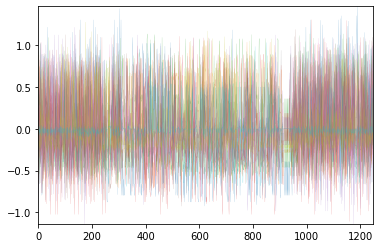

In [399]:
plt.plot(pc_hvc)

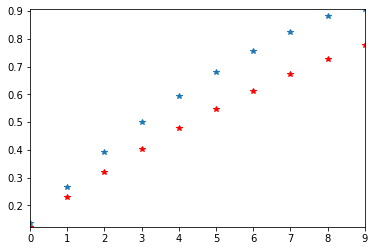

In [401]:
plt.plot(pca_ra.explained_variance_ratio_.cumsum(), 'r*')
plt.plot(pca_hvc.explained_variance_ratio_.cumsum(), '*')

In [381]:
pca_hvc.explained_variance_ratio_.cumsum()

array([0.13821702, 0.26647582, 0.39093754, 0.49862427, 0.59246108,
       0.67937757, 0.75698878, 0.82434353, 0.88032961, 0.90594687])

<ipython-input-195-ca374ab1f158>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')


<AxesSubplot:>

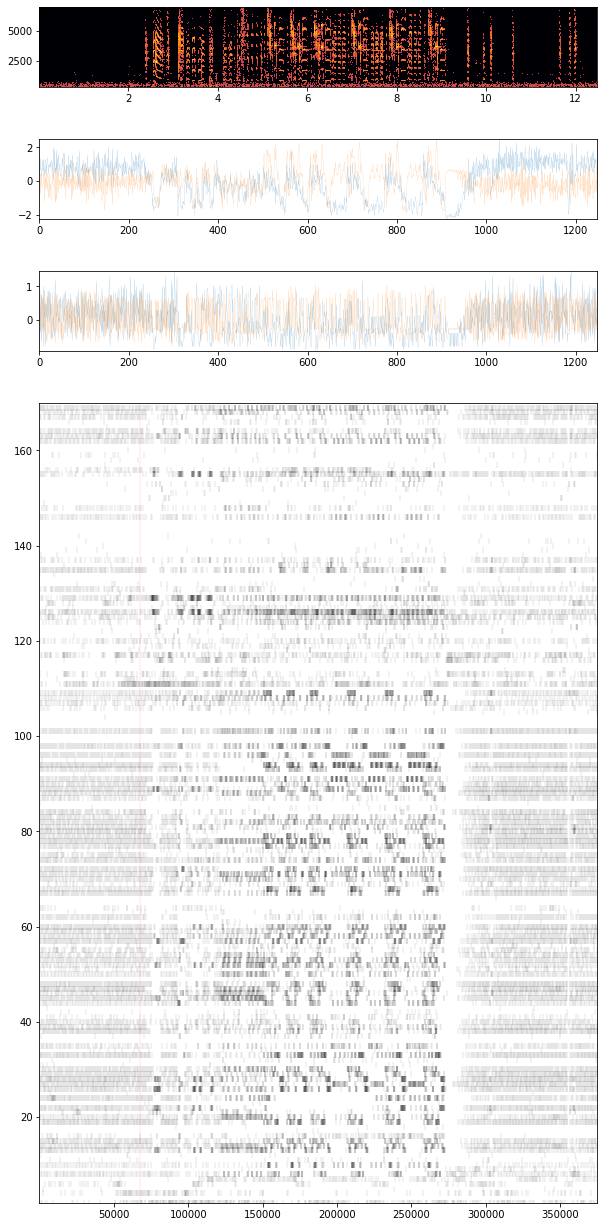

In [195]:
spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=4, gridspec_kw={'height_ratios': [1, 1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)


ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

ax[1].plot(pc_ra)
ax[2].plot(pc_hvc)


pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[3])



In [214]:
pc_ra.shape

(1250, 2)

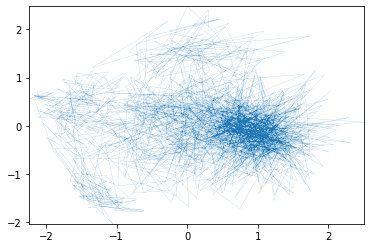

In [367]:
plt.plot(*pc_ra[:,:].T, '-')

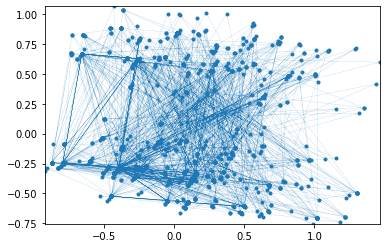

In [275]:
plt.plot(*pc_hvc.T, '.-')

In [ ]:
### TODO
- NMF factorization
- color code the time
- look at it on a motif 
- shuffle each cell spike train inependently in time


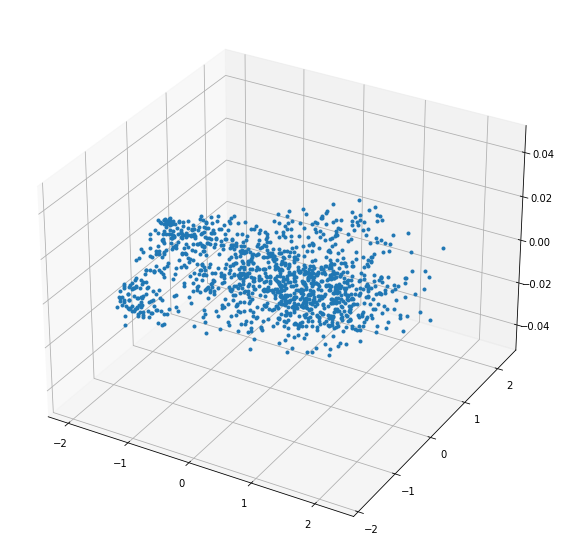

In [281]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*pc_ra.T, '-.')

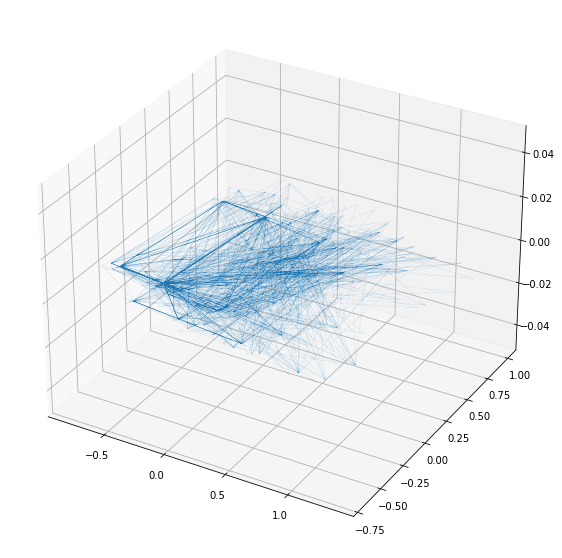

In [282]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*pc_hvc.T, '-.')

In [137]:
spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[2])

(139, 139)

<ipython-input-108-4f6b49285573>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')


<AxesSubplot:>

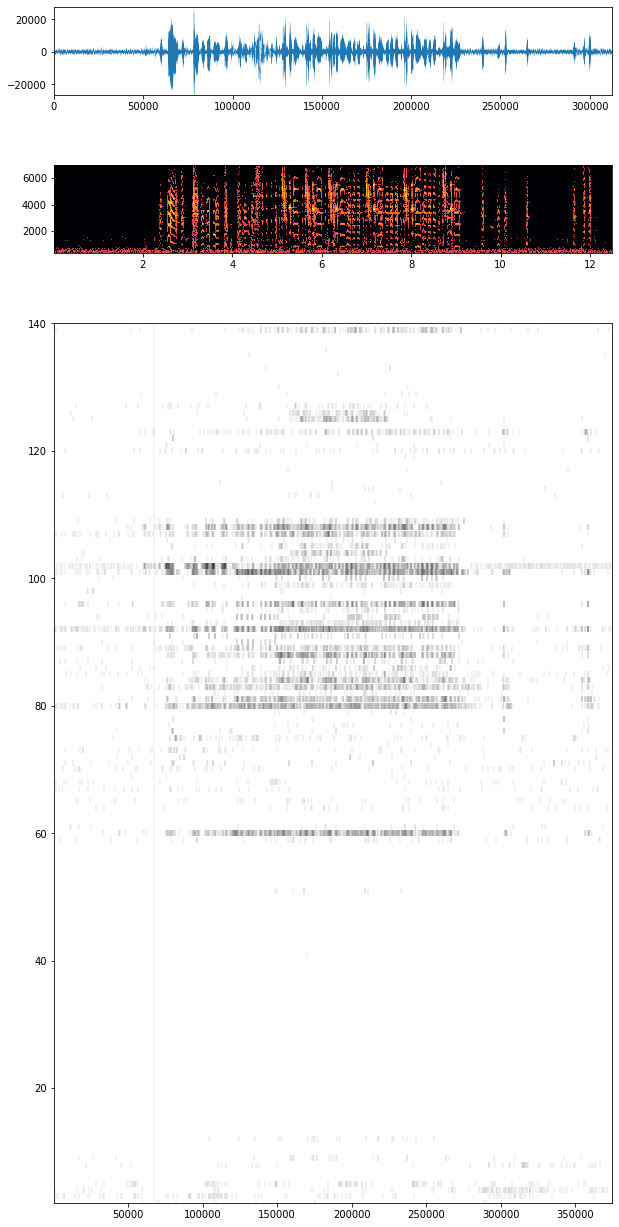

In [108]:
mua_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

spk_arr = get_window_spikes(spk_df, mua_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[2])

In [95]:
spk_arr.shape

(169, 375001)

In [635]:
clu_df.head(1)

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
0,0,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 1, 3, 4, 5, 23, 25, 21, 24, 18, 17, 10,...",0,"[0, 1, 2, 3, 4, 5, 23]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [106]:
clu_df['KSLabel']

0      good
1      good
5      good
7      good
14     good
       ... 
808     mua
813     mua
814     mua
807     mua
815     mua
Name: KSLabel, Length: 1077, dtype: object

In [639]:
clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])),:]

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
170,170,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[50, 48, 49, 51, 52, 54, 47, 46, 53, 44, 55, 5...",50,"[47, 48, 49, 50, 51, 52, 54]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
176,176,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[50, 52, 49, 51, 48, 56, 47, 46, 53, 43, 54, 5...",50,"[47, 48, 49, 50, 51, 52, 56]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
179,179,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[51, 49, 48, 45, 47, 53, 57, 52, 50, 55, 43, 4...",51,"[45, 47, 48, 49, 51, 53, 57]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
180,180,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[51, 52, 48, 49, 50, 46, 53, 54, 45, 47, 44, 6...",51,"[46, 48, 49, 50, 51, 52, 53]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
181,181,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[51, 52, 50, 53, 49, 54, 56, 57, 48, 55, 46, 4...",51,"[49, 50, 51, 52, 53, 54, 56]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra
...,...,...,...,...,...,...,...,...
997,997,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[310, 311, 312, 308, 305, 309, 313, 307, 314, ...",310,"[305, 308, 309, 310, 311, 312, 313]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",hvc
777,777,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[313, 311, 309, 308, 312, 307, 317, 315, 306, ...",313,"[307, 308, 309, 311, 312, 313, 317]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",hvc
778,778,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[314, 316, 312, 317, 313, 319, 315, 321, 310, ...",314,"[312, 313, 314, 315, 316, 317, 319]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",hvc
782,782,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[318, 317, 316, 319, 314, 323, 321, 324, 312, ...",318,"[314, 316, 317, 318, 319, 321, 323]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",hvc


In [ ]:
clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])

In [648]:
### get window spikes for ra/hvc during the bout
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 'cluster_id'])

#spk_arr = get_window_spikes(spk_df, clu_list, ap_samples[0] + t_pre_samp, ap_samples[0] + t_post_samp)

In [649]:
clu_list

array([ 170,  176,  179,  180,  181,  182,  183,  184,  186,  187,  188,
        189,  190,  191,  194,  197,  198,  199,  200,  204,  205,  206,
        208,  210,  211,  212,  214,  215,  217,  218,  219,  221,  226,
        229,  230,  232,  233,  236,  237,  238,  239,  242,  243,  244,
        245,  249,  253,  254,  255,  256,  259,  261,  262,  263,  264,
        266,  269,  270,  271,  272,  275,  276,  277,  278,  279,  280,
        281,  284,  286,  287,  288,  289,  290,  293,  294,  300,  301,
        302,  303,  304,  306,  307,  308,  309,  313,  314,  316,  317,
        318,  319,  320,  322,  323,  326,  327,  328,  331,  333,  334,
        335,  336,  337,  338,  340,  342,  343,  344,  345,  346,  347,
        348,  727,  731,  732,  734,  735,  739,  740,  741,  742,  746,
        747,  757,  762,  777,  778,  782,  783,  854,  855,  857,  858,
        859,  860,  862,  864,  865,  868,  869,  871,  872,  874,  875,
        876,  877,  878,  879,  880,  984,  985,  9

In [399]:
t_pre_samp

-12499

In [400]:
rast_arr.shape

(593, 49998, 10)

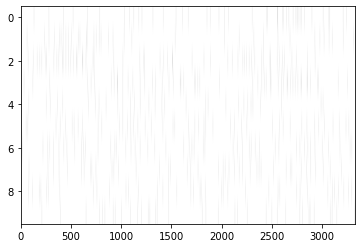

In [401]:
def coarse(x: np.ndarray, n_coarse: int):
    # coarse x along last dimension in bins of n_coarse size
    x_shape = x.shape
    last_dim = x.shape[-1]
    
    max_n = last_dim//n_coarse * n_coarse # chop it to the max integer coarse
    exploded_x = x[..., :max_n].reshape(*x_shape[:-1], -1, n_coarse)
    coarse_x = exploded_x.mean(axis=-1)
    return coarse_x

### get it in miliseconds
samples_in_ms = int(run_recordings['ap_0']._s_f_0 * 0.001)
samples_in_ms


clu_idx =  6 ##idx of the clu in the array
one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms//2)

one_raster_ms[one_raster_ms>0] = 1
one_raster_ms[one_raster_ms<0] = -1

plt.imshow((one_raster_ms[::-1]), aspect='auto', cmap='Greys')

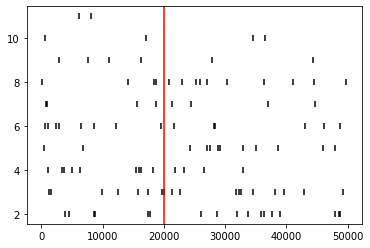

In [402]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='|', facecolor='k', rasterized=True)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

clu_idx = 105
ax = plot_as_raster(rast_arr[clu_idx].T, t_0=20000)

IndexError: index 200 is out of bounds for axis 0 with size 169

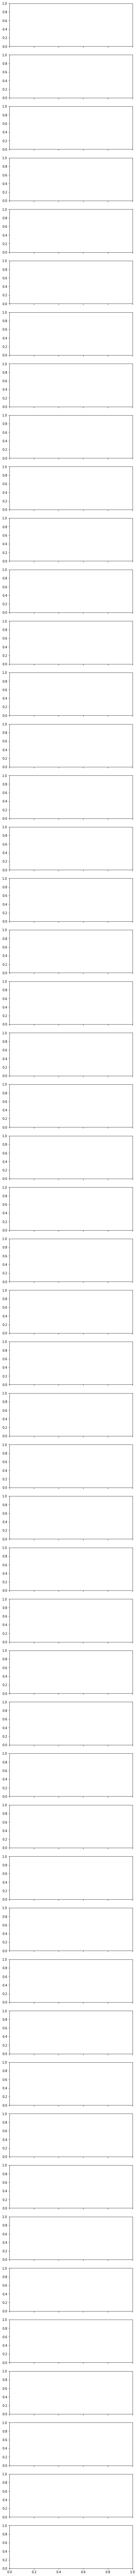

In [294]:
#### plot 50 rasters
fig, ax_arr = plt.subplots(nrows=50, figsize=[7, 150], sharex=True)

for i_rast, clu_idx in enumerate(range(200, 250)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    plot_as_raster(rast_arr[clu_idx].T, t_0=20000, ax=ax_arr[i_rast])

In [404]:
np.nansum(one_raster_ms)

433.0

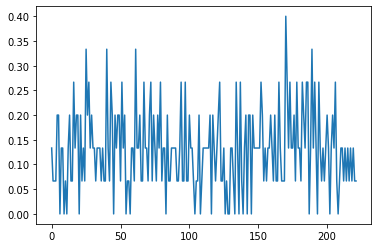

In [405]:
plt.plot(coarse(np.nansum(one_raster_ms, axis=0), 15))

In [279]:
np.stack(spk_arr_list, axis=-1).shape

(593, 10, 15000)

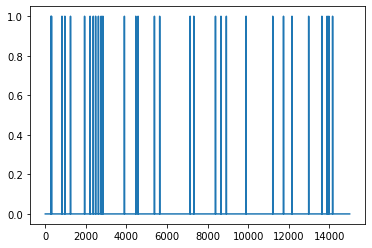

In [292]:
plt.plot(rast_arr[clu_idx].sum(axis=1))

In [293]:
rast_arr[clu_idx].shape

(15000, 10)

In [285]:
one_raster_ms

array([], shape=(15000, 0), dtype=float64)

<ipython-input-280-0df3c8c7bcdc>:1: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')


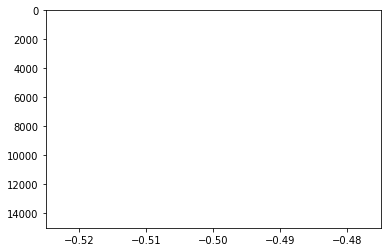

In [280]:
plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')

In [270]:
spk_arr.shape

(593, 4000)

In [269]:
clu_list

array([   0,    1,    5,    7,   13,   14,   16,   17,   18,   21,   22,
         23,   25,   26,   27,   28,   30,   32,   34,   35,   36,   40,
         42,   43,   44,   46,   47,   49,   51,   52,   53,   56,   57,
         58,   59,   62,   63,   64,   65,   68,   69,   70,   71,   74,
         75,   77,   78,   80,   82,   83,   87,   88,   90,   91,   92,
         95,   96,   97,   98,   99,  102,  103,  104,  105,  106,  109,
        110,  111,  113,  114,  115,  117,  118,  121,  123,  124,  128,
        129,  130,  132,  135,  136,  137,  138,  140,  141,  142,  143,
        144,  145,  146,  150,  151,  152,  153,  155,  157,  158,  159,
        160,  161,  162,  165,  166,  167,  168,  170,  176,  179,  180,
        181,  182,  183,  184,  186,  187,  188,  189,  190,  191,  194,
        197,  198,  199,  200,  204,  205,  206,  208,  210,  211,  212,
        214,  215,  217,  218,  219,  221,  226,  229,  230,  232,  233,
        236,  237,  238,  239,  242,  243,  244,  2

In [198]:
loaded_sort.get_unit_property_names(5)

['Amplitude', 'ContamPct', 'KSLabel', 'quality']

In [206]:
loaded_sort.get_unit_property(5, 'KSLabel')

'good'

In [207]:
loaded_sort.get_units_spike_train([5])

[array([   101649,    285124,    285299, ..., 229055603, 229230185,
        229235620], dtype=uint64)]

In [ ]:
loaded_sort.get_unit_property(5, 'KSLabel')

In [101]:
u_wf = st.postprocessing.get_unit_waveforms(ap_extractor_filt, loaded_sort, unit_ids=[0, 1], 
                                            ms_before=0.5, ms_after=0.5,
                                          save_as_features=True, verbose=True,
                                           **{'n_jobs': 40,
                                           'max_spikes_per_unit': 100})

Number of chunks: 14087 - Number of jobs: 40


In [106]:
u_wf[0].shape

(100, 384, 28)

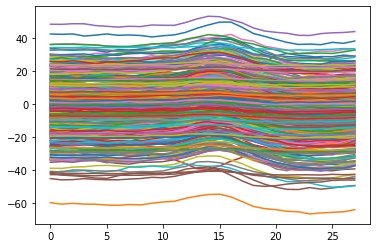

In [111]:
plt.plot(u_wf[1].mean(axis=0).T);

In [115]:
u_wf = st.postprocessing.get_unit_max_channels(ap_extractor_filt, loaded_sort, unit_ids=[0, 1], 
                                            ms_before=0.5, ms_after=0.5,
                                          save_as_features=True, verbose=True,
                                           **{'n_jobs': 40,
                                           'max_spikes_per_unit': 100})

Number of chunks: 14087 - Number of jobs: 40
Number of chunks: 14087 - Number of jobs: 40


In [98]:
all_unit_id = np.array(loaded_sort.get_unit_ids())

In [99]:
loaded_sort.get_unit_property(5, 'pc_features')

ValueError: pc_features has not been added to unit 5

In [119]:
u_wf

[0, 0]

In [116]:
loaded_sort.get_shared_unit_spike_feature_names(unit_ids=[0,1])

['amplitudes', 'pc_features', 'waveforms', 'waveforms_idxs']

In [54]:
snrs = st.validation.compute_snrs(loaded_sort, ap_extractor)


In [56]:
isi_violations = st.validation.compute_isi_violations(loaded_sort, 
                                                      duration_in_frames=ap_extractor.get_num_frames())

In [58]:
wf = st.postprocessing.get_unit_waveforms(ap_extractor, loaded_sort, ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [60]:
wf[0].shape

(1000, 384, 178)

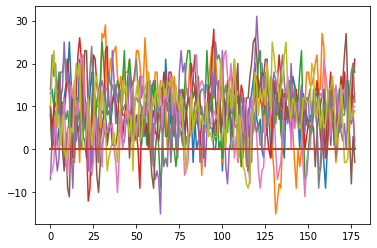

In [86]:
plt.plot(wf[13][:, 0, :].T);

In [72]:
max_chan = st.postprocessing.get_unit_max_channels(ap_extractor, loaded_sort, save_as_property=True, verbose=True)

In [86]:
templates = st.postprocessing.get_unit_templates(ap_extractor, loaded_sort, save_as_property=True, verbose=True)

Number of chunks: 353 - Number of jobs: 1


KeyboardInterrupt: 

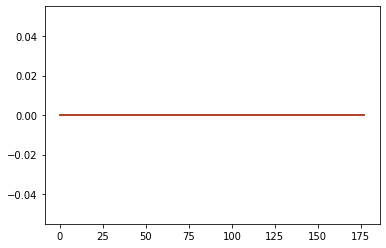

In [90]:
plt.plot(templates[0].T);

In [78]:
np.where(np.array(max_chan)>0)

(array([  5,  13,  23,  36,  44,  59,  72,  73,  84, 117, 126, 200, 250,
        259]),)

In [85]:
loaded_sort.get_unit_property(15, 'max_channel')

ValueError: max_channel has not been added to unit 15

### load the npy objects from kilosort

In [92]:
spk_clu = np.load(os.path.join(tmp_loc, 'tmp_ks2', 'spike_clusters.npy'))
spk_templates = np.load(os.path.join(tmp_loc, 'tmp_ks2', 'templates.npy'))

In [97]:
np.unique(spk_clu).shape

(272,)

In [93]:
spk_templates.shape

(314, 82, 371)

## Try with sglexp
make a pandas dataframe to keep track of epochs (folders), runs within each session, caryying the recording extractors

In [122]:
from ceciestunepipe.util import sglxexp as sgle

In [126]:
reload(sgle)
epoch_pd = sgle.make_sgl_epoch_dict(sess_par, sess_epochs[1])

In [127]:
epoch_pd

,bird,sess,run,nidq,lf_0,ap_0,rec-nidq,rec-lf_0,rec-ap_0
0,z_w12m7_20,20201104,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...


In [138]:
reload(sgle)
sess_pd = sgle.make_session_pd(sess_par)
sess_pd

2021-01-28 11:52:14,246 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'tmp': '/scratch/earneodo/tmp/tmp', 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/stream.kwd', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/sort_2/

,bird,sess,epoch,run,nidq,lf_0,ap_0,rec-nidq,rec-lf_0,rec-ap_0
0,z_w12m7_20,20201104,2500r250a_3500_dir_g0,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
1,z_w12m7_20,20201104,2500r250a_3500_dir_g1,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
2,z_w12m7_20,20201104,2500r250a_3500_dir_g2,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...


### get some metadata

In [137]:
def get_sess_pd_meta(sess_pd: pd.DataFrame) -> pd.DataFrame:
    # fields to pick from the sglx metadata
    sglx_fields = {}
    

,bird,sess,epoch,run,nidq,lf_0,ap_0,rec-nidq,rec-lf_0,rec-ap_0
0,z_w12m7_20,20201104,2500r250a_3500_dir_g0,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
1,z_w12m7_20,20201104,2500r250a_3500_dir_g1,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
2,z_w12m7_20,20201104,2500r250a_3500_dir_g2,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...


### sort a merged recording extractor with all of the session epochs, runs

In [193]:
def merge_pd(sess_pd: pd.DataFrame) -> pd.DataFrame:
    
    # get the list of existing recordings (one per stream)
    rec_list = [c for c in (sess_pd.columns) if 'rec' in c]
    
    # merge each column
    merged_rec_dict = {c: se.MultiRecordingTimeExtractor(recordings=list(sess_pd.loc[:, c].values)) for c in rec_list}
    
    merged_pd = pd.DataFrame.from_dict(merged_rec_dict, orient='index').T
    merged_pd['bird'] = sess_pd['bird']
    merged_pd['sess'] = sess_pd['sess']
    merged_pd['epoch'] = [list(sess_pd.loc[:, 'epoch'].values)]*len(merged_pd)
    merged_pd['run'] = [list(sess_pd.loc[:, 'run'].values)]*len(merged_pd)
    
    return merged_pd

reload(sgle)
merged_pd = sgle.merge_session_pd(sess_pd)

In [194]:
merged_pd

,rec-nidq,rec-lf_0,rec-ap_0,bird,sess,epoch,run
0,<spikeextractors.multirecordingtimeextractor.M...,<spikeextractors.multirecordingtimeextractor.M...,<spikeextractors.multirecordingtimeextractor.M...,z_w12m7_20,20201104,"[2500r250a_3500_dir_g0, 2500r250a_3500_dir_g1,...","[0, 0, 0]"


In [195]:
merged_pd.loc[0, 'rec-lf_0']

In [197]:
merged_exp_struct = sglu.sgl_struct(sess_par, 'merge')
merged_exp_struct

{'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/merge',
  'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/merge',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/merge',
  'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/merge',
  'tmp': '/scratch/earneodo/tmp/tmp/merge',
  'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104/merge',
  'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge'},
 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/params.json',
  'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf',
  'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json',
  'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/merge/stream.kwd',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/202

In [198]:
tmp_loc

'/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2'

In [ ]:
sort_pickle_path = os.path.join(merged_exp_struct['folders']['ksort'], 'sort_ks2.pickle')
tmp_loc = merged_exp_struct['folders']['ksort']

sort = run_spikesort(merged_pd.loc[0, 'rec-ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

2021-01-28 23:56:25,540 root         INFO     Grouping property: None
2021-01-28 23:56:25,542 root         INFO     sorting method: kilosort2
2021-01-28 23:56:25,543 root         INFO     Sorting tmp dir /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/tmp_ks2
2021-01-28 23:56:25,545 root         INFO     Will set visible gpu devices 1


In [80]:
sort